### GrappaNet, one of the great work on MRI reconstruction was published in 2020. We tried to implement it since code was not available.  The paper can be found here https://arxiv.org/pdf/1910.12325v4.pdf

Our Dataset is small and acquired with different imaging conditions than fastMRI dataset. This example has been shown for MRIs acquired with 9 coils. Unlike GrappNet paper we have precalculated grappa weights and reused during training. However, Model was trained in eager mode and consumes significant amount of time and GPU Memory for each epoch. We trained our model on 80 GB Apollo GPU

## Import libraries and Prepare Dataset 

In [1]:
import random, h5py, os, glob, sys, time
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft 
from medpy.io import save, load
from pygrappa import grappa,mdgrappa
import tensorflow as tf
from utils import estimate_mdgrappa_kernel, Grappa_recon, calculate_mask, comp_sub_kspace, comp_img, apply_kernel_weight

os.environ['HDF5_USE_FILE_LOCKING']='FALSE'
#assign MRI file locations
path_to_save_data="" 
input_mris = '' # input data location
crop_size=(18,512,192)
channel=18 #9 coils-- real+imaginary components
file_pattern="rawdata*"
all_files=sorted(glob.glob(input_mris+file_pattern))


## Estimate Grappa Weight for each MRI (K-space)

In [68]:

cnt=1
crop_size_2=(crop_size[0]/2,crop_size[1],crop_size[1])
last_mask=None
X_train=[]
Y_train=[]
grappa_wt=[]
grappa_p=[]

#iterate over all files in the input directory provided above
for mri_f in sorted(all_files[:70]):
    filename=os.path.basename(mri_f)
    filename=filename.replace(".h5","")
    with h5py.File(mri_f,'r') as f:

        k = f['kspace'][()]
        mrh = f['ismrmrd_header'][()]
        loopcoils=f.attrs['loopcoils']
        #sensitivity=f['sensitivity'][()]
        #referrence=f['reference'][()]
        nSL, nCh, nFE, nPE = k.shape
        
        mid=nPE//2
        start=mid-int(nPE*0.05)
        end=mid+int(nPE*0.05)
        
        
        #print(loopcoils)
        mask=0*k
        mask[:,:,:,start:end]=1
        mask=calculate_mask(mask,start,end,nPE)## add you maskfunction here  
        last_mask=mask
        subsampled_k=k*mask
       
        for slices in range(nSL): 
            ref_img=np.zeros((nCh,nFE,nPE),dtype=np.float)
            sub_kspace=np.zeros((nCh*2,nFE,nPE),dtype=np.float)
            wt,ps=estimate_mdgrappa_kernel(kspace=subsampled_k[slices,:,:,:],calib=None, kernel_size=(5, 5),coil_axis=0) 
            for iCh in [0,1,2,3,4,5,6,7,8]:
                    ref_img[iCh,:,:]=abs(fft.fftshift(fft.ifft2(k[slices,iCh,:,:])))
                    sub_kspace[iCh,:,:]=subsampled_k[slices,iCh,:,:].real
                    sub_kspace[iCh+9,:,:]=subsampled_k[slices,iCh,:,:].imag
            X_train.append(list(comp_sub_kspace(sub_kspace)))
            Y_train.append(list(comp_img(ref_img)))
            grappa_wt.append(wt)
            grappa_p.append(ps)
            #save(np.transpose(comp_img(sub_img),(2,1,0)),path+'scratch/'+filename+'_sub_'+str(slices)+".nrrd", use_compression=False)
            #save(np.transpose(comp_img(ref_img),(2,1,0)),path+'scratch/'+filename+'_ref_'+str(slices)+".nrrd", use_compression=False)
        print(cnt,filename,f.attrs['acquisition'],nSL, nCh, nFE, nPE,loopcoils,start,end,"grappa: ")
    
      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


1 rawdata_150001_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150002_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150003_T1 T1 115 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150004_T1 T1 93 9 456 163 [0 1] 73 89 grappa: 
1 rawdata_150005_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150006_T1 T1 128 9 480 172 [0 1] 78 94 grappa: 
1 rawdata_150007_T1 T1 104 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150008_T1 T1 126 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150009_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150010_T1 T1 110 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150011_T1 T1 128 9 496 179 [0 1] 81 97 grappa: 
1 rawdata_150012_T1 T1 118 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150013_T1 T1 103 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150014_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150015_T1 T1 128 9 448 168 [0 1] 76 92 grappa: 
1 rawdata_150016_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 rawdata_150017_T1 T1 128 9 504 183 [0 1] 82 100 grappa: 
1 

## Save the MRIs and estimated weight since it takes long time

In [69]:

Y_train=np.array(Y_train).astype(np.float32)
X_train=np.array(X_train).astype(np.float32)

np.save(path_to_save_data+"2d_trainig_grappaNet_data_PE_9colis.npy",X_train) #save data since you may need later
np.save(path_to_save_data+"2d_trainig_GT_grappaNet_data_PE_colis.npy",Y_train)
with open('grapp_wt.pickle', 'wb') as handle:
    pickle.dump(grappa_wt, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
with open('grapp_hole.pickle', 'wb') as handle:
    pickle.dump(grappa_p, handle, protocol=pickle.HIGHEST_PROTOCOL)




## Calculate RSS that will be used as reference

In [5]:

X_train = np.transpose(X_train,(0,2,3,1))
Y_rss=np.sqrt(np.sum(np.square(Y_train),axis=1))
Y_rss=Y_rss.astype(np.float32)
print(X_train.shape,Y_rss.shape)

(8657, 512, 192, 18) (8657, 512, 192)


## Normalize the data

In [6]:

dims=X_train.shape
print(dims)
for i in range(dims[0]):
    for j in range(dims[3]):
        X_train[i,:,:,j]=X_train[i,:,:,j]/((np.max(X_train[i,:,:,j])-np.min(X_train[i,:,:,j]))+1e-10)

for i in range(dims[0]):
    Y_rss[i,:,:]=Y_rss[i,:,:]/((np.max(Y_rss[i,:,:])-np.min(Y_rss[i,:,:]))+1e-10)

(8657, 512, 192, 18)


## Split the data into train and Test.  10% used for Validation

In [5]:
x_train=X_train[0:int(X_train.shape[0]-X_train.shape[0]*0.1),:,:,:]
y_train=Y_rss[0:int(X_train.shape[0]-X_train.shape[0]*0.1),:,:]
x_test=X_train[int(X_train.shape[0]-X_train.shape[0]*0.1):,:,:,:]
y_test=Y_rss[int(X_train.shape[0]-X_train.shape[0]*0.1):,:,:]
y_test=np.reshape(y_test, (X_train.shape[0]*0.1,512,192))

grappa_train_indx=np.array(range(0,int(X_train.shape[0]-X_train.shape[0]*0.1)),dtype=int)
grappa_test_indx=np.array(range(int(X_train.shape[0]-X_train.shape[0]*0.1),X_train.shape[0]),dtype=int)

(7791, 512, 192, 18) (7791, 512, 192, 1)


## visualize a sample to check everything looks ok

In [8]:
index=200
ref_img=abs(fft.fftshift(fft.ifft2(x_train[index,:,:,:])))

fix, ax=plt.subplots(nrows=2,ncols=2,figsize=(10,12))
ax[0,0].imshow(ref_img[0,:,:],cmap='gray')
ax[0,1].imshow(ref_img[1,:,:],cmap='gray')
ax[1,0].imshow(ref_img[2,:,:],cmap='gray')
ax[1,1].imshow(ref_img[3,:,:],cmap='gray')
ax[1,1].imshow(Y_rss[indx,:,:],cmap='gray')

plt.show()

NameError: name 'res' is not defined

## Build Model. The precalculated grappa weight will be used to eliminate redundant calculation.  

In [23]:
import os, gc
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#del model
model=None
gc.collect()

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,BatchNormalization, Activation,Conv2D,ZeroPadding2D,MaxPooling2D,Reshape, AveragePooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU,add, Attention, Dropout, Lambda, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow_addons as tfa
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
kernel_size=(3,3)
lamda=0.001

@tf.function
def model_loss_ssim(y_true, y_pred):
    global lamda
    ssim_loss=0
    max_val=1.0
    if tf.reduce_max(y_pred)>1.0:
        max_val=tf.reduce_max(y_pred)
    ssim_loss=tf.math.abs(tf.reduce_mean(tf.image.ssim(img1=y_true, img2=y_pred,max_val=max_val,filter_size=3, filter_sigma=0.1)))
    l1_loss=lamda*tf.reduce_mean(tf.math.abs(y_true-y_pred))
    return 1-ssim_loss +l1_loss
    
def conv_block(ip, nfilters,drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)

    #layer_top =BatchNormalization()(layer_top)
    layer_top = tfa.layers.InstanceNormalization(axis=3,center=True, 
                                                 scale=True,beta_initializer="random_uniform",
                                                 gamma_initializer="random_uniform")(layer_top)
    res_model=ReLU()(layer_top)
    res_model=Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model = tfa.layers.InstanceNormalization(axis=3, center=True, 
                                                 scale=True,beta_initializer="random_uniform",
                                                 gamma_initializer="random_uniform")(res_model)
    #res_model =BatchNormalization()(res_model)
    res_model=Dropout(drop_rate)(res_model)
    res_model=add([layer_top,res_model])
    res_model=ReLU()(res_model)
    return res_model

def encoder(inp,nlayers, nbasefilters, drop_rate):
    
    skip_layers=[]
    layers=inp
    for i in range(nlayers):
        layers=conv_block(layers,nbasefilters*2**i,drop_rate)
        skip_layers.append(layers)
        layers=MaxPooling2D((2,2))(layers)
    return layers, skip_layers


def decoder(inp,nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers=inp
    for i in range(nlayers):
        layers=conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        layers=UpSampling2D(size=(2,2),  interpolation='bilinear')(layers)
        layers=add([layers,skip_layers.pop()])
    
    return layers


def create_gen(gen_ip, nlayers,nbasefilters,lambda_l, drop_rate):
    op, skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op=decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(18, (3,3), padding = "same")(op)
    return op

def custom_data_consistency(tensors):
    output= tf.where(tf.greater_equal(tensors[0], 1), tensors[0], tensors[1])
    out_cmplx=tf.complex(output[:,:,:,0:9], output[:,:,:,9:18])
    ift_sig=tf.signal.fftshift(tf.signal.ifft2d(out_cmplx, name=None))
    real_p=tf.math.real(ift_sig)
    imag_p=tf.math.imag(ift_sig)
    comb=tf.concat(axis=-1,values=[real_p, imag_p])
    #print("here",output.get_shape(),ift_sig.get_shape(),real_p.get_shape(),comb.get_shape(),tensors[0].get_shape())
    return comb

def custom_data_consistency_2(tensors):
    out_cmplx=tf.complex(tensors[1][:,:,:,0:9], tensors[1][:,:,:,9:18])
    ft_sig=tf.signal.fftshift(tf.signal.fft2d(out_cmplx, name=None))
    real_p=tf.math.real(ft_sig)
    imag_p=tf.math.imag(ft_sig)
    comb=tf.concat(axis=-1,values=[real_p, imag_p])
    output= tf.where(tf.greater_equal(tensors[0], 1), tensors[0], comb)
    return output

def aux_Grappa_layer(tensor1, tensor2):
    global grappa_wt
    global grappa_p
    t1=tensor1.numpy()
    t2=tensor2.numpy()
    #print("max",np.max(t1),np.max(t2),print(t1.shape))

    x_train_cmplx_target=t2[:,:,:,0:9]+1j*t2[:,:,:,9:18]
    x_train_cmplx_target=np.transpose(x_train_cmplx_target,(0,3,1,2))
    l_grappa=[]
    for i in range(x_train_cmplx_target.shape[0]):
        res= apply_kernel_weight(kspace=x_train_cmplx_target[i],calib=None,
                                 kernel_size=(5, 5),coil_axis=0,
                                 weights=grappa_wt[int(t1[i][0])],P=grappa_p[int(t1[i][0])])
        res=np.transpose(res,(1,2,0))
        out_cmplx_real=tf.convert_to_tensor(res.real)
        out_cmplx_imag=tf.convert_to_tensor(res.imag)
        comb=tf.concat(axis=2,values=[out_cmplx_real, out_cmplx_imag])
        l_grappa.append(comb)
    b_grappa=tf.stack(l_grappa)
    #print("grappa",b_grappa.get_shape())
    return b_grappa
    

def Grappa_layer(tensor):
    #print(tensor[1].get_shape())
    out_tensor=tf.py_function(func=aux_Grappa_layer, inp=tensor, Tout=tf.float32)
    out_tensor.set_shape(tensor[1].get_shape())
    #print(out_tensor.get_shape())
    return out_tensor
    


def ift_RSS(tensor):
    cmplx_tensor=tf.complex(tensor[:,:,:,0:9], tensor[:,:,:,9:18])
    ift_sig=tf.signal.fftshift(tf.signal.ifft2d(cmplx_tensor, name=None))
    Y_rss=tf.math.sqrt(tf.math.reduce_sum(tf.square(tf.math.abs(ift_sig)),axis=3))
    
    return Y_rss


def build_model(input_shape,n_filter=32,n_depth=4,lamda=1,dropout_rate=0.05):

    #first pass
    input_layer=Input(shape=input_shape)
    input_layer_grappa_wt_indx=Input(shape=(1))
    kspace_u1=create_gen(input_layer,n_depth,n_filter,lamda,dropout_rate)
    data_con_layer= Lambda(custom_data_consistency, name="data_const_K_u1")([input_layer, kspace_u1])
    img_space_u1=create_gen(data_con_layer,n_depth,n_filter,lamda,dropout_rate)
    data_con_layer= Lambda(custom_data_consistency_2, name="data_const_K_u1_2")([input_layer, img_space_u1])
    grappa_recon_k=Lambda(Grappa_layer, name="data_const_K_2")([input_layer_grappa_wt_indx, data_con_layer])
    
    
    #second Pass
    kspace_u2=create_gen(grappa_recon_k,n_depth,n_filter,lamda,dropout_rate)
    data_con_layer= Lambda(custom_data_consistency, name="data_const_K_u2")([input_layer, kspace_u2])
    img_space_u2=create_gen(data_con_layer,n_depth,n_filter,lamda,dropout_rate)
    data_con_layer= Lambda(custom_data_consistency_2, name="data_const_K_u2_2")([input_layer, img_space_u2])
    
    #IFT+RSS
    data_con_layer= Lambda(ift_RSS, name="IFT_RSS")(data_con_layer)
    return Model(inputs=[input_layer,input_layer_grappa_wt_indx],outputs=data_con_layer)



## Train Model. Model will be trained in eager mode

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler 
from tensorflow.keras.callbacks import TensorBoard ,ReduceLROnPlateau, EarlyStopping
model_name="weights/model_grappaNet.h5"
def step_decay(epoch, initial_lrate, drop, epochs_drop):
    return initial_lrate * math.pow(drop, math.floor((1+epoch)/float(epochs_drop)))

def get_callbacks(model_file, learning_rate_drop=0.7,learning_rate_patience=7, verbosity=1):
    callbacks = list()
    #callbacks.append(TensorBoard(log_dir='weights/Graph', histogram_freq=0, write_graph=True, write_images=True))
    callbacks.append(ModelCheckpoint(model_file, save_best_only=True))
    callbacks.append(ReduceLROnPlateau(factor=learning_rate_drop, patience=learning_rate_patience,verbose=verbosity))
    callbacks.append(EarlyStopping(verbose=verbosity, patience=200))
    return callbacks

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    input_shape=(512,192,18)
    epochs=200
    batch_size=64
    model=build_model(input_shape)
    metrics=tf.keras.metrics.RootMeanSquaredError()
    #model.compile(loss=model_loss_ssim, optimizer= Adam(learning_rate=0.0003),metrics=[metrics])
    model.compile(loss=model_loss_ssim, optimizer= RMSprop(learning_rate=0.0003),metrics=[metrics])


In [26]:
model.summary()
#del X_train
#del Y_train

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 192, 18 0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 512, 192, 32) 5216        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 512, 192, 32) 128         conv2d_136[0][0]                 
__________________________________________________________________________________________________
re_lu_128 (ReLU)                (None, 512, 192, 32) 0           batch_normalization_128[0][0]    
____________________________________________________________________________________________

In [ ]:
history=model.fit([x_train,grappa_train_indx], y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            validation_data=([x_test,grappa_test_indx], y_test),
            callbacks=get_callbacks(model_name,0.6,10,1),
            max_queue_size=32,                # maximum size for the generator queue
            workers=100,
            use_multiprocessing=False
             )

model_json = model.to_json()
with open("weights/model_grappaNet_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights/model_grappaNet_json.h5")
print("Saved model to disk")

Epoch 1/200
 64/122 [==============>...............] - ETA: 34:56 - loss: 0.0361 - root_mean_squared_error: 11.6880

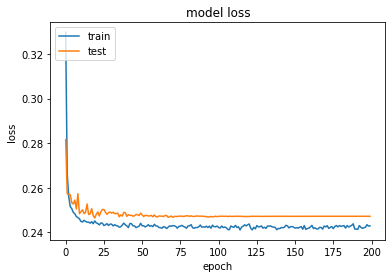

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
from tensorflow.keras.models import load_model
#model.load_weights("weights/model_grappaNet.h5")
ex_recons_imgs = model.predict([x_test,grappa_test_indx])